In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/aws_food_reviews/Reviews.csv')
print(df.shape)
#Making a sample
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


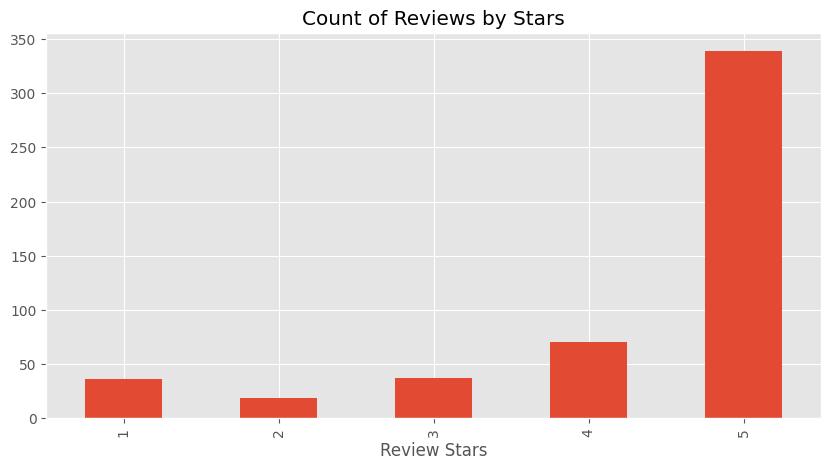

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Modelling

In this section I will apply some of pretrained models for text sentiment recognize.

## VADER Seniment Scoring

- VADER is a sentiment analysis tool widely used in natural language processing (NLP). It is especially useful for assessing text sentiment on social media and short texts.

- Isn't a complex machine learning model, but rather a dictionary-based approach. It uses a lexicon (dictionary) with compound words according to their polarity (positive, negative or neutral) and intensity.

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [7]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [9]:
vaders.head(5)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


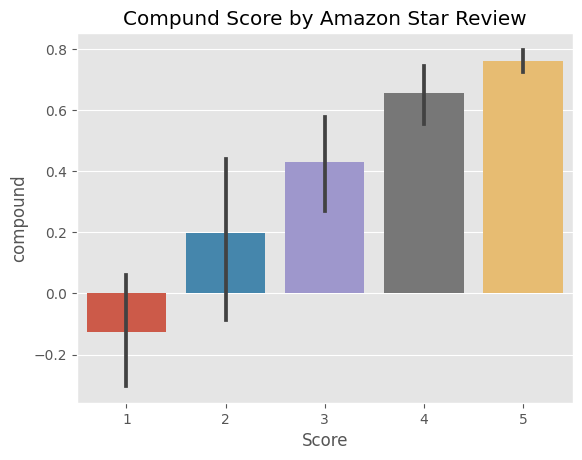

In [10]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

## Roberta Pretrained Model

- It is a variation of BERT (Bidirectional Encoder Representations from Transformers) that has been trained with additional optimizations and on a large volume of data.

- RoBERTa is widely used in NLP tasks such as text classification, text generation, machine translation and more.

- It is known to outperform many other pre-trained models in various tasks and is used as the basis for many cutting-edge NLP models.

In [11]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [12]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [13]:
example = df['Text'].iloc[0]

In [14]:
print(example)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [15]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [16]:
polarity_scores_roberta(example)

{'roberta_neg': 0.009624243,
 'roberta_neu': 0.049980447,
 'roberta_pos': 0.9403953}

Gathering vader and roberta results.

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [19]:
results_df.head(5)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Comparing

In [20]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)[['Text', 'roberta_neg', 'roberta_neu' ,'roberta_pos']].head(1)

,Text,roberta_neg,roberta_neu,roberta_pos
252,"I felt energized within five minutes, but it l...",0.059614,0.314749,0.625637


In [21]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)[['Text', 'vader_neg', 'vader_neu' ,'vader_pos']].head(1)

,Text,vader_neg,vader_neu,vader_pos
322,So we cancelled the order. It was cancelled w...,0.213,0.514,0.274


In [22]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)[['Text', 'roberta_neg', 'roberta_neu' ,'roberta_pos']].head(1)

,Text,roberta_neg,roberta_neu,roberta_pos
69,this was sooooo deliscious but too bad i ate e...,0.960158,0.035429,0.004413


In [23]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)[['Text', 'vader_neg', 'vader_neu' ,'vader_pos']].head(1)

,Text,vader_neg,vader_neu,vader_pos
69,this was sooooo deliscious but too bad i ate e...,0.344,0.52,0.136
